
#  the model in this file comes from this website

#  https://geertlitjens.nl/post/getting-started-with-camelyon/



#  without editing the model, it is 80% accurate/confident

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import tensorflow as tf
import tensorflow_datasets as tfds

pcam, pcam_info = tfds.load('patch_camelyon', shuffle_files=True, with_info=True,
                            data_dir='/content/drive/My Drive/Colab Notebooks')
print(pcam_info)

tfds.core.DatasetInfo(
    name='patch_camelyon',
    version=2.0.0,
    description='The PatchCamelyon benchmark is a new and challenging image classification
dataset. It consists of 327.680 color images (96 x 96px) extracted from
histopathologic scans of lymph node sections. Each image is annoted with a
binary label indicating presence of metastatic tissue. PCam provides a new
benchmark for machine learning models: bigger than CIFAR10, smaller than
Imagenet, trainable on a single GPU.
',
    homepage='https://patchcamelyon.grand-challenge.org/',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(96, 96, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=327680,
    splits={
        'test': 32768,
        'train': 262144,
        'validation': 32768,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{b_s_veeling_j_linmans_j_winkens_t_cohen_2018

In [0]:
# Import NumPy to handle array's and Matplotlib for plotting loss curves
import numpy as np
import matplotlib.pyplot as plt

# Import TensorFlow and relevant Keras classes to setup the model
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [18]:
#just some network parameters, see above link regarding the layers for details
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

#dropout is used for regularization here with a probability of 0.3 for conv layers, 0.5 for the dense layer at the end
dropout_conv = 0.3
dropout_dense = 0.5

#initialize the model
model = Sequential()

#now add layers to it

#conv block 1
model.add(Conv2D(first_filters, kernel_size, input_shape = (96, 96, 1)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

#conv block 2
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

#conv block 3
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(GlobalAveragePooling2D())

#a fully connected (also called dense) layer at the end
model.add(Flatten())
model.add(Dense(128, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout_dense))

model.add(Dense(2, activation = "softmax"))

model.compile(optimizer=Adam(1e-4),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 94, 94, 32)        320       
_________________________________________________________________
batch_normalization_8 (Batch (None, 94, 94, 32)        128       
_________________________________________________________________
activation_8 (Activation)    (None, 94, 94, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 45, 45, 64)        18432     
_________________________________________________________________
batch_normalization_9 (Batch (None, 45, 45, 64)       

In [0]:
def convert_sample(sample):
    image, label = sample['image'], sample['label']  
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.rgb_to_grayscale(image)
    label = tf.one_hot(label, 2, dtype=tf.float32)
    return image, label

In [0]:
train_pipeline = pcam['train'].map(convert_sample,
                                   num_parallel_calls=8).shuffle(1024).repeat().batch(128).prefetch(2)
valid_pipeline = pcam['validation'].map(convert_sample,
                                        num_parallel_calls=8).repeat().batch(128).prefetch(2)

early_stopping_cb = EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint_cb = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=2, save_best_only=True)
callbacks_list = [early_stopping_cb, model_checkpoint_cb]

In [21]:
hist = model.fit(train_pipeline,
                 validation_data=valid_pipeline, callbacks=callbacks_list,
                 verbose=2, epochs=20, steps_per_epoch=2048, validation_steps=256)

Epoch 1/20

Epoch 00001: val_loss improved from inf to 0.44718, saving model to best_model.h5
2048/2048 - 192s - loss: 0.5089 - accuracy: 0.7684 - val_loss: 0.4472 - val_accuracy: 0.7877
Epoch 2/20

Epoch 00002: val_loss improved from 0.44718 to 0.44359, saving model to best_model.h5
2048/2048 - 191s - loss: 0.4515 - accuracy: 0.7966 - val_loss: 0.4436 - val_accuracy: 0.7988
Epoch 3/20

Epoch 00003: val_loss did not improve from 0.44359
2048/2048 - 192s - loss: 0.4264 - accuracy: 0.8102 - val_loss: 0.4959 - val_accuracy: 0.7918
Epoch 4/20

Epoch 00004: val_loss did not improve from 0.44359
2048/2048 - 191s - loss: 0.4114 - accuracy: 0.8177 - val_loss: 0.4903 - val_accuracy: 0.7946
Epoch 5/20

Epoch 00005: val_loss did not improve from 0.44359
2048/2048 - 195s - loss: 0.3994 - accuracy: 0.8243 - val_loss: 0.5460 - val_accuracy: 0.7848
Epoch 6/20

Epoch 00006: val_loss did not improve from 0.44359
2048/2048 - 192s - loss: 0.3885 - accuracy: 0.8294 - val_loss: 0.5046 - val_accuracy: 0.786

In [22]:
best_model = load_model('best_model.h5')
test_pipeline = pcam['test'].map(convert_sample, num_parallel_calls=8).batch(128).prefetch(2)
print("Test set accuracy is {0:.4f}".format(best_model.evaluate(test_pipeline, steps=128, verbose=0)[1]))

Test set accuracy is 0.8148


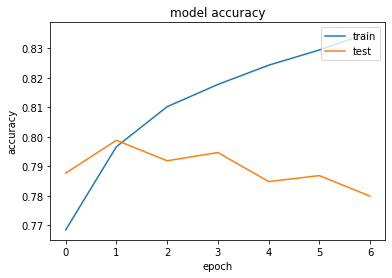

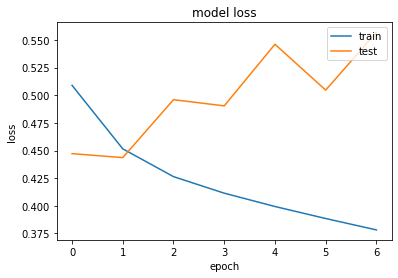

In [23]:
plt.figure()
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# summarize history for loss
plt.figure()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [24]:
# Code below from https://www.kaggle.com/georsara1/95-auc-score-in-train-sample-with-neural-nets

#Import modules
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras import optimizers
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
%matplotlib inline
sns.set_style("whitegrid")
np.random.seed(697)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [25]:
#Predict on test set
predictions_NN_prob = best_model.predict(test_pipeline)
print(predictions_NN_prob)
predictions_NN_prob = predictions_NN_prob[:,0]

predictions_NN_01 = np.where(predictions_NN_prob > 0.5, 0, 1) #Turn probability to 0-1 binary output

[[0.06233105 0.937669  ]
 [0.9844924  0.01550754]
 [0.07287953 0.92712045]
 ...
 [0.31418577 0.6858142 ]
 [0.96795774 0.03204231]
 [0.9262551  0.07374488]]


[0 1 0 ... 1 0 1]


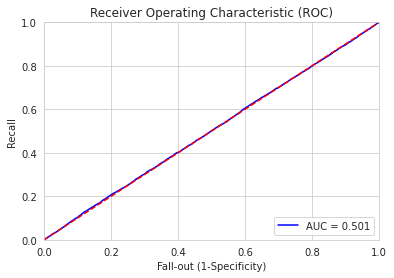

In [26]:
#Print Area Under Curve
y_numpy = pcam['test'].as_numpy_iterator()
test_y = np.array([i['label'] for i in y_numpy])
print(test_y)
false_positive_rate, recall, thresholds = roc_curve(test_y, predictions_NN_prob)
roc_auc = auc(false_positive_rate, recall)
plt.figure()
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

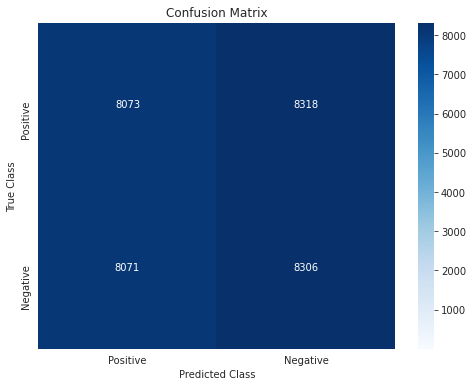

In [27]:
#Print Confusion Matrix
cm = confusion_matrix(test_y, predictions_NN_01)
labels = ['Positive', 'Negative']
plt.figure(figsize=(8,6))
sns.heatmap(cm,xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()